#Definisi Churn

Didefinisikan beberapa tipe customer sebagai berikut:


1.   Customer yang churn adalah customer yang melakukan pembelian pada bulan Januari-April 2022 tetapi tidak melakukan pembelian pada bulan Mei-Juli 2022.
2.   Customer yang tidak churn adalah customer yang melakukan pembelian pada bulan Januari-April 2022 dan melakukan pembelian pada bulan Mei-Juli 2022.
3.   New Customer adalah customer yang tidak melakukan pembelian pada bulan Januari-April 2022 tetapi melakukan pembelian pada bulan Mei-Juli 2022.
4.   Inactive Customer adalah customer yang tidak melakukan pembelian pada bulan Januari-April 2022 dan bulan Mei-Juli 2022


# Pre-Processing

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import datetime
from dateutil import tz
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("drive/MyDrive/Mockup Datasets")

In [ ]:
transaction= pd.read_csv("transactions.csv")
customer = pd.read_csv("customer.csv")
click_stream = pd.read_csv("click_stream.csv")
product = pd.read_csv("product.csv", on_bad_lines = "skip" )

## Clickstream Data

### Data Cleaning

In [ ]:
click_stream.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [ ]:
click_stream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833602 entries, 0 to 12833601
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   session_id      object
 1   event_name      object
 2   event_time      object
 3   event_id        object
 4   traffic_source  object
 5   event_metadata  object
dtypes: object(6)
memory usage: 587.5+ MB


In [ ]:
click_stream.isnull().value_counts()

session_id  event_name  event_time  event_id  traffic_source  event_metadata
False       False       False       False     False           True              8544062
                                                              False             4289540
dtype: int64

In [ ]:
click_stream.duplicated().value_counts()

False    12833602
dtype: int64

### Feature Engineering

In [ ]:
click_stream_mod = click_stream[['session_id','event_name','traffic_source']]

In [ ]:
click_stream_mod.head()

,session_id,event_name,traffic_source
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,MOBILE
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,MOBILE
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,MOBILE
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,MOBILE
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,MOBILE


In [ ]:
click_stream_mod2 = click_stream_mod

In [ ]:
traffic_source = pd.get_dummies(click_stream_mod['traffic_source'], drop_first = False)
traffic_source.columns= traffic_source.columns.str.lower()

In [ ]:
event_name = pd.get_dummies(click_stream_mod['event_name'], drop_first = False)
event_name.columns= event_name.columns.str.lower()

In [ ]:
click_stream_mod3 = pd.concat([click_stream_mod2,traffic_source],sort=False,axis=1)

In [ ]:
click_stream_mod3 = pd.concat([click_stream_mod3,event_name],sort=False,axis=1)

In [ ]:
click_stream_mod3.head()

,session_id,event_name,traffic_source,mobile,web,add_promo,add_to_cart,booking,click,homepage,item_detail,promo_page,scroll,search
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,MOBILE,1,0,0,0,0,0,1,0,0,0,0
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,MOBILE,1,0,0,0,0,0,0,0,0,1,0
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,MOBILE,1,0,0,0,0,0,1,0,0,0,0
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,MOBILE,1,0,0,1,0,0,0,0,0,0,0
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,MOBILE,1,0,0,0,1,0,0,0,0,0,0


In [ ]:
click_stream_mod3.drop(columns=['event_name','traffic_source'],inplace=True)

#### Splitting Data

In [ ]:
#click_stream_metadata = click_stream[['session_id','event_metadata']]

In [ ]:
#a = 2566720

#for i in range(1,6):
 # if i<5:
    #print(a*(i-1), a*i)
 # elif i==5:
  #  print(a*(i-1),12833602)

In [ ]:
#click_stream_metadata_p1 = click_stream_metadata.loc[0:2566721,:]
#click_stream_metadata_p2 = click_stream_metadata.loc[2566720:5133441,:]
#click_stream_metadata_p3 = click_stream_metadata.loc[5133440:7700161,:]
#click_stream_metadata_p4 = click_stream_metadata.loc[7700160:10266881,:]
#click_stream_metadata_p5 = click_stream_metadata.loc[10266880:12833603,:]

In [ ]:
#click_stream_metadata.head()

In [ ]:
#event_metadata_p1 = click_stream_metadata_p1[click_stream_metadata_p1["event_metadata"].notnull()]

In [ ]:
#event_metadata_p1

In [ ]:
#event_metadata_met_p1 = event_metadata_p1.loc[:100000,"event_metadata"].apply(lambda x: pd.Series(eval(x)))

In [ ]:
#event_metadata_met_p1

## Product Data

### Data Cleaning

In [ ]:
product.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [ ]:
product.isnull().value_counts()

id     gender  masterCategory  subCategory  articleType  baseColour  season  year   usage  productDisplayName
False  False   False           False        False        False       False   False  False  False                 44077
                                                                                    True   False                   309
                                                                     True    False  False  False                    20
                                                         True        False   False  False  False                     7
                                                                                    True   True                      5
                                                                                           False                     3
                                                         False       False   False  False  True                      2
                                                         

In [ ]:
product.duplicated().value_counts()

False    44424
dtype: int64

### EDA

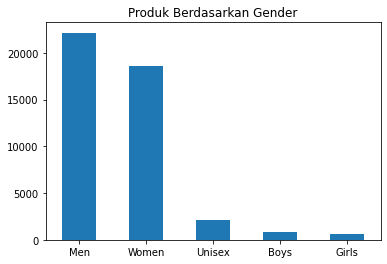

In [ ]:
product['gender'].value_counts().plot.bar(rot=0, title='Produk Berdasarkan Gender')

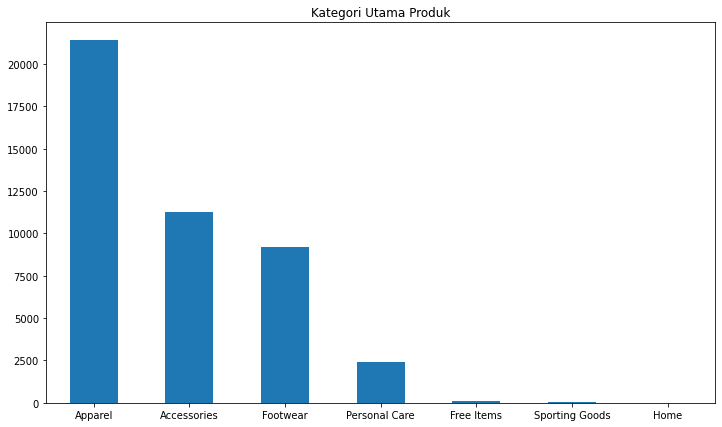

In [ ]:
product['masterCategory'].value_counts().plot.bar(rot=0,figsize=(12,7),title='Kategori Utama Produk')

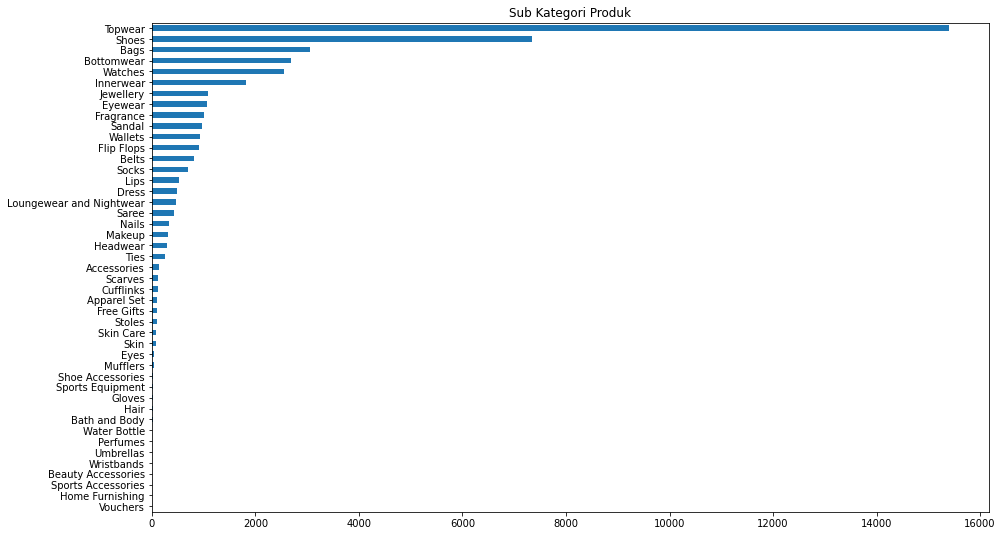

In [ ]:
product['subCategory'].value_counts(ascending=True).plot.barh(rot=0,figsize=(15,9), title='Sub Kategori Produk')

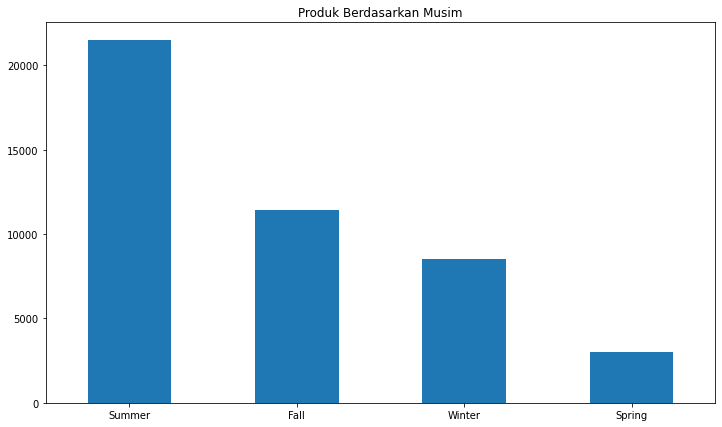

In [ ]:
product['season'].value_counts().plot.bar(rot=0,figsize=(12,7),title='Produk Berdasarkan Musim')

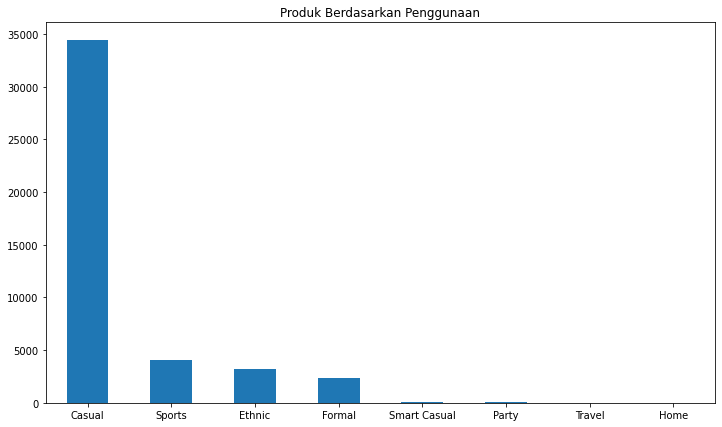

In [ ]:
product['usage'].value_counts().plot.bar(rot=0,figsize=(12,7),title='Produk Berdasarkan Penggunaan')

## Transaction Data

### Data Cleaning

In [ ]:
transaction.head()

,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753


In [ ]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852584 entries, 0 to 852583
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   created_at              852584 non-null  object 
 1   customer_id             852584 non-null  int64  
 2   booking_id              852584 non-null  object 
 3   session_id              852584 non-null  object 
 4   product_metadata        852584 non-null  object 
 5   payment_method          852584 non-null  object 
 6   payment_status          852584 non-null  object 
 7   promo_amount            852584 non-null  int64  
 8   promo_code              326536 non-null  object 
 9   shipment_fee            852584 non-null  int64  
 10  shipment_date_limit     852584 non-null  object 
 11  shipment_location_lat   852584 non-null  float64
 12  shipment_location_long  852584 non-null  float64
 13  total_amount            852584 non-null  int64  
dtypes: float64(2), int64

In [ ]:
transaction.isnull().value_counts()

created_at  customer_id  booking_id  session_id  product_metadata  payment_method  payment_status  promo_amount  promo_code  shipment_fee  shipment_date_limit  shipment_location_lat  shipment_location_long  total_amount
False       False        False       False       False             False           False           False         True        False         False                False                  False                   False           526048
                                                                                                                 False       False         False                False                  False                   False           326536
dtype: int64

In [ ]:
transaction.duplicated().value_counts()

False    852584
dtype: int64

### EDA

####Metode Pembayaran

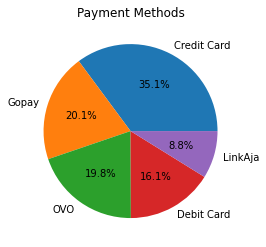

In [ ]:
transaction['payment_method'].value_counts().plot.pie(autopct = '%1.1f%%',ylabel='',title='Payment Methods')

#### Status Pembelian

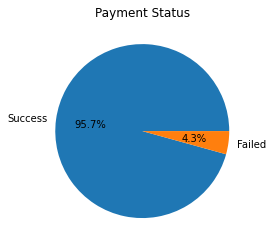

In [ ]:
transaction['payment_status'].value_counts().plot.pie(autopct = '%1.1f%%',ylabel='',title='Payment Status')

#### Kode Promo

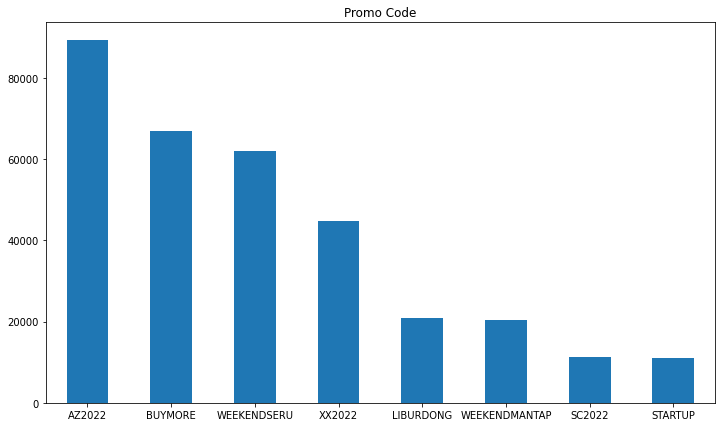

In [ ]:
transaction['promo_code'].value_counts().plot.bar(title='Promo Code',rot=0,figsize=((12,7)))

#### Ongkos Kirim

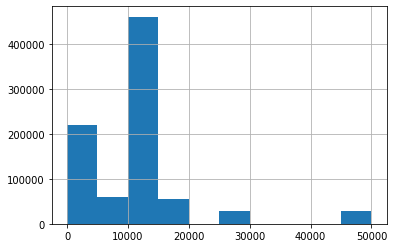

In [ ]:
transaction['shipment_fee'].hist()

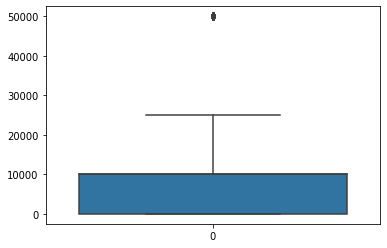

In [ ]:
sn.boxplot(data=transaction['shipment_fee'])

#### Total Pembayaran

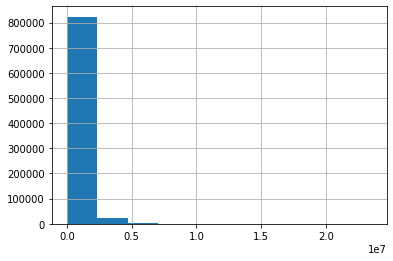

In [ ]:
transaction['total_amount'].hist()

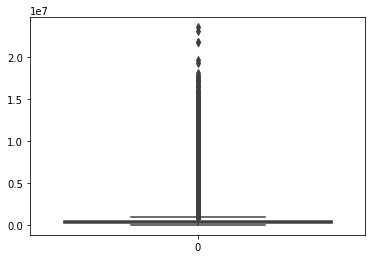

In [ ]:
sn.boxplot(data=transaction['total_amount'])

### Feature Engineering

In [ ]:
transaction['created_at'] = pd.to_datetime(pd.to_datetime(transaction['created_at']).apply(lambda t: t.strftime('%Y-%m-%d %H:%M:%S')))

In [ ]:
transaction['created_at']

0        2018-07-29 15:22:01
1        2018-07-30 12:40:22
2        2018-09-15 11:51:17
3        2018-11-01 11:23:48
4        2018-12-18 11:20:30
                 ...        
852579   2021-09-21 22:10:05
852580   2021-12-09 07:35:18
852581   2021-12-11 01:20:36
852582   2019-12-18 11:01:09
852583   2019-12-19 12:47:14
Name: created_at, Length: 852584, dtype: datetime64[ns]

In [ ]:
transaction['payment_status'].value_counts()

Success    815964
Failed      36620
Name: payment_status, dtype: int64

In [ ]:
transaction.columns

Index(['created_at', 'customer_id', 'booking_id', 'session_id',
       'product_metadata', 'payment_method', 'payment_status', 'promo_amount',
       'promo_code', 'shipment_fee', 'shipment_date_limit',
       'shipment_location_lat', 'shipment_location_long', 'total_amount'],
      dtype='object')

In [ ]:
pay_method = pd.get_dummies(transaction['payment_method'], drop_first = False)
pay_status = pd.get_dummies(transaction['payment_status'], drop_first = False)

In [ ]:
trans_add = pd.concat([pay_method,pay_status],sort=False,axis=1)

In [ ]:
transaction_mod = pd.concat([transaction,trans_add], sort=False,axis=1)

In [ ]:
transaction_mod.head()

,created_at,customer_id,booking_id,session_id,product_metadata,payment_method,payment_status,promo_amount,promo_code,shipment_fee,...,shipment_location_lat,shipment_location_long,total_amount,Credit Card,Debit Card,Gopay,LinkAja,OVO,Failed,Success
0,2018-07-29 15:22:01,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,"[{'product_id': 54728, 'quantity': 1, 'item_pr...",Debit Card,Success,1415,WEEKENDSERU,10000,...,-8.227893,111.969107,199832,0,1,0,0,0,0,1
1,2018-07-30 12:40:22,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,"[{'product_id': 16193, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,10000,...,3.013470,107.802514,155526,1,0,0,0,0,0,1
2,2018-09-15 11:51:17,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,"[{'product_id': 53686, 'quantity': 4, 'item_pr...",OVO,Success,0,NaN,10000,...,-2.579428,115.743885,550696,0,0,0,0,1,0,1
3,2018-11-01 11:23:48,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,"[{'product_id': 20228, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,...,-3.602334,120.363824,271012,1,0,0,0,0,0,1
4,2018-12-18 11:20:30,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,"[{'product_id': 55220, 'quantity': 1, 'item_pr...",Credit Card,Success,0,NaN,0,...,-3.602334,120.363824,198753,1,0,0,0,0,0,1


In [ ]:
transaction_mod.drop(columns=['booking_id', 'payment_method', 'payment_status',
       'product_metadata',
       'promo_code', 'shipment_date_limit',
       'shipment_location_lat', 'shipment_location_long'],inplace=True)

In [ ]:
transaction_mod.columns

Index(['created_at', 'customer_id', 'session_id', 'promo_amount',
       'shipment_fee', 'total_amount', 'Credit Card', 'Debit Card', 'Gopay',
       'LinkAja', 'OVO', 'Failed', 'Success'],
      dtype='object')

In [ ]:
transaction_mod.head()

,created_at,customer_id,session_id,promo_amount,shipment_fee,total_amount,Credit Card,Debit Card,Gopay,LinkAja,OVO,Failed,Success
0,2018-07-29 15:22:01,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,0,1,0,0,0,0,1
1,2018-07-30 12:40:22,4774,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,1,0,0,0,0,0,1
2,2018-09-15 11:51:17,4774,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,0,0,0,0,1,0,1
3,2018-11-01 11:23:48,4774,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,1,0,0,0,0,0,1
4,2018-12-18 11:20:30,4774,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,1,0,0,0,0,0,1


In [ ]:
transaction_mod.rename(columns = {'Credit Card':'credit_card','Debit Card':'debit_card','Gopay':'gopay','LinkAja':'linkaja','OVO':'ovo','Failed':'fail_transaction','Success':'success_transaction'},inplace=True)

In [ ]:
transaction_mod.head()

,created_at,customer_id,session_id,promo_amount,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction
0,2018-07-29 15:22:01,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,0,1,0,0,0,0,1
1,2018-07-30 12:40:22,4774,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,1,0,0,0,0,0,1
2,2018-09-15 11:51:17,4774,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,0,0,0,0,1,0,1
3,2018-11-01 11:23:48,4774,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,1,0,0,0,0,0,1
4,2018-12-18 11:20:30,4774,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,1,0,0,0,0,0,1


In [ ]:
def month(x):
  return x.month

def year(x):
  return x.year

In [ ]:
transaction_mod['buy_month'] = transaction_mod['created_at'].apply(lambda x: month(x) )

In [ ]:
transaction_mod['buy_year'] = transaction_mod['created_at'].apply(lambda x: year(x) )

In [ ]:
transaction_mod

,created_at,customer_id,session_id,promo_amount,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,buy_month,buy_year
0,2018-07-29 15:22:01,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,0,1,0,0,0,0,1,7,2018
1,2018-07-30 12:40:22,4774,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,1,0,0,0,0,0,1,7,2018
2,2018-09-15 11:51:17,4774,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,0,0,0,0,1,0,1,9,2018
3,2018-11-01 11:23:48,4774,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,1,0,0,0,0,0,1,11,2018
4,2018-12-18 11:20:30,4774,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,1,0,0,0,0,0,1,12,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852579,2021-09-21 22:10:05,25121,484eecde-9f4a-42de-a8df-7ce6668101f4,0,0,226820,0,1,0,0,0,1,0,9,2021
852580,2021-12-09 07:35:18,34829,954e1211-4d45-4d0b-ba84-53e80119592c,5010,10000,359203,0,0,0,0,1,0,1,12,2021
852581,2021-12-11 01:20:36,99645,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,2181,5000,1158159,1,0,0,0,0,0,1,12,2021
852582,2019-12-18 11:01:09,87319,bb6e5426-a3f3-426a-b99d-79173eaa234b,4503,0,184143,1,0,0,0,0,0,1,12,2019


In [ ]:
transaction_mod_2022 = transaction_mod[transaction_mod['buy_year']==2022]

In [ ]:
transaction_mod_2022['buy_month'].max()

7

In [ ]:
def b_cutoff(x):
  if x == 1 or x== 2 or x == 3 or x == 4:
    return 1
  elif x == 5 or x== 6 or x == 7:
    return 0

In [ ]:
def a_cutoff(x):
  if x == 1 or x== 2 or x == 3 or x == 4:
    return 0
  elif x == 5 or x== 6 or x == 7:
    return 1

In [ ]:
transaction_mod_2022['before_cutoff'] = transaction_mod_2022['buy_month'].apply(lambda x: b_cutoff(x))

<ipython-input-67-699dcbed6ae6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_mod_2022['before_cutoff'] = transaction_mod_2022['buy_month'].apply(lambda x: b_cutoff(x))


In [ ]:
transaction_mod_2022['after_cutoff'] = transaction_mod_2022['buy_month'].apply(lambda x: a_cutoff(x))

<ipython-input-68-6286ec9b2961>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transaction_mod_2022['after_cutoff'] = transaction_mod_2022['buy_month'].apply(lambda x: a_cutoff(x))


In [ ]:
transaction_mod_2022

,created_at,customer_id,session_id,promo_amount,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,buy_month,buy_year,before_cutoff,after_cutoff
28,2022-01-19 11:25:46,4774,5d3d5de2-3a5a-42e9-8f8c-512346a4c031,0,5000,1078709,1,0,0,0,0,0,1,1,2022,1,0
29,2022-03-07 10:53:30,4774,514d9158-5020-4dd9-8ca0-22097c600b78,7255,10000,311231,0,1,0,0,0,0,1,3,2022,1,0
30,2022-04-23 11:43:52,4774,7e644152-6798-4511-8c27-0648ebff6e17,7079,10000,117133,1,0,0,0,0,0,1,4,2022,1,0
31,2022-06-09 12:18:09,4774,1688279e-d03f-466a-a20e-57846de4c179,3329,50000,245215,1,0,0,0,0,0,1,6,2022,0,1
116,2022-01-09 18:44:40,58191,6240caad-6a41-4cf5-bcff-90df3090fabe,4063,10000,369557,0,0,0,0,1,0,1,1,2022,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852564,2022-01-10 13:51:41,64772,b4a2ca36-4250-47cb-b799-89db41316b1b,0,10000,196191,0,0,0,0,1,0,1,1,2022,1,0
852572,2022-04-15 01:10:55,37287,5d3f98ea-08d8-42a4-813d-28cb0a36ebdf,4890,15000,246186,0,0,0,0,1,0,1,4,2022,1,0
852573,2022-05-09 19:43:52,99675,531d6aff-923b-4d3b-801c-eaa2c376162d,5177,0,387326,1,0,0,0,0,0,1,5,2022,0,1
852574,2022-06-08 02:44:08,99675,8d71b0a4-e0f8-47ea-9de4-b11c0db924c1,0,0,237077,1,0,0,0,0,0,1,6,2022,0,1


In [ ]:
transaction_mod_2022_class = transaction_mod_2022[['before_cutoff','after_cutoff']]

In [ ]:
transaction_mod2 = pd.concat([transaction_mod,transaction_mod_2022_class],sort=False,axis=1)

In [ ]:
transaction_mod2

,created_at,customer_id,session_id,promo_amount,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,buy_month,buy_year,before_cutoff,after_cutoff
0,2018-07-29 15:22:01,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,0,1,0,0,0,0,1,7,2018,NaN,NaN
1,2018-07-30 12:40:22,4774,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,1,0,0,0,0,0,1,7,2018,NaN,NaN
2,2018-09-15 11:51:17,4774,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,0,0,0,0,1,0,1,9,2018,NaN,NaN
3,2018-11-01 11:23:48,4774,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,1,0,0,0,0,0,1,11,2018,NaN,NaN
4,2018-12-18 11:20:30,4774,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,1,0,0,0,0,0,1,12,2018,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852579,2021-09-21 22:10:05,25121,484eecde-9f4a-42de-a8df-7ce6668101f4,0,0,226820,0,1,0,0,0,1,0,9,2021,NaN,NaN
852580,2021-12-09 07:35:18,34829,954e1211-4d45-4d0b-ba84-53e80119592c,5010,10000,359203,0,0,0,0,1,0,1,12,2021,NaN,NaN
852581,2021-12-11 01:20:36,99645,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,2181,5000,1158159,1,0,0,0,0,0,1,12,2021,NaN,NaN
852582,2019-12-18 11:01:09,87319,bb6e5426-a3f3-426a-b99d-79173eaa234b,4503,0,184143,1,0,0,0,0,0,1,12,2019,NaN,NaN


In [ ]:
transaction_class_all = transaction_mod2[['before_cutoff','after_cutoff']].fillna(0).astype(int)

In [ ]:
transaction_mod2.drop(columns=['before_cutoff','after_cutoff'], inplace=True)

In [ ]:
transaction_mod2 = pd.concat([transaction_mod2,transaction_class_all],sort=False,axis=1)

In [ ]:
transaction_mod2

,created_at,customer_id,session_id,promo_amount,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,buy_month,buy_year,before_cutoff,after_cutoff
0,2018-07-29 15:22:01,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,1415,10000,199832,0,1,0,0,0,0,1,7,2018,0,0
1,2018-07-30 12:40:22,4774,2ee5ead1-f13e-4759-92df-7ff48475e970,0,10000,155526,1,0,0,0,0,0,1,7,2018,0,0
2,2018-09-15 11:51:17,4774,93325fb6-eb00-4268-bb0e-6471795a0ad0,0,10000,550696,0,0,0,0,1,0,1,9,2018,0,0
3,2018-11-01 11:23:48,4774,bcad5a61-1b67-448d-8ff4-781d67bc56e4,0,0,271012,1,0,0,0,0,0,1,11,2018,0,0
4,2018-12-18 11:20:30,4774,df1042ab-13e6-4072-b9d2-64a81974c51a,0,0,198753,1,0,0,0,0,0,1,12,2018,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852579,2021-09-21 22:10:05,25121,484eecde-9f4a-42de-a8df-7ce6668101f4,0,0,226820,0,1,0,0,0,1,0,9,2021,0,0
852580,2021-12-09 07:35:18,34829,954e1211-4d45-4d0b-ba84-53e80119592c,5010,10000,359203,0,0,0,0,1,0,1,12,2021,0,0
852581,2021-12-11 01:20:36,99645,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,2181,5000,1158159,1,0,0,0,0,0,1,12,2021,0,0
852582,2019-12-18 11:01:09,87319,bb6e5426-a3f3-426a-b99d-79173eaa234b,4503,0,184143,1,0,0,0,0,0,1,12,2019,0,0


In [ ]:
transaction_mod3 = transaction_mod2.drop(columns=['session_id','created_at','buy_month','buy_year']).groupby('customer_id',
                                    as_index=False).agg({'promo_amount': lambda x: sum(x),
                                                       'shipment_fee': lambda x: sum(x),
                                                       'total_amount': lambda x: sum(x),
                                                       'credit_card': lambda x: max(x),
                                                       'debit_card': lambda x: max(x),
                                                       'gopay': lambda x: max(x),
                                                       'linkaja': lambda x: max(x),
                                                       'ovo': lambda x: max(x),
                                                       'fail_transaction': lambda x: sum(x),
                                                       'success_transaction': lambda x: sum(x),
                                                       'before_cutoff': lambda x: max(x),
                                                       'after_cutoff': lambda x: max(x),
                                                      },
                                                      )

In [ ]:
transaction_mod3

,customer_id,promo_amount,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,before_cutoff,after_cutoff
0,3,131082,365000,21265889,1,1,1,1,1,2,49,1,1
1,8,7699,45000,3898561,1,0,0,0,1,0,7,1,1
2,9,0,35000,2638665,1,0,1,0,0,0,6,1,1
3,11,9492,15000,197533,0,0,0,0,1,0,1,1,0
4,15,16362,50000,2134870,1,0,1,1,0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50700,99992,12442,130000,4352229,0,1,1,0,1,0,12,1,1
50701,99995,63674,550000,36043743,1,1,1,1,1,1,59,1,1
50702,99997,0,10000,226461,0,0,1,0,0,0,1,0,0
50703,99998,30325,55000,6692540,1,1,0,0,0,0,8,1,0


#### Churn Label

In [ ]:
def f(x1,x2):
  if x1 == 1 and x2 == 1:
    return 'not_churn'
  elif x1 == 1 and x2 == 0:
    return 'churn'
  elif x1 == 0 and x2 == 1:
    return 'new'
  elif x1 == 0 and x2 == 0:
    return 'inactive'

In [ ]:
transaction_mod3['customer_type'] = transaction_mod3[['before_cutoff','after_cutoff']].apply(lambda x: f(x[0],x[1]), axis=1)

In [ ]:
transaction_mod3

,customer_id,promo_amount,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,before_cutoff,after_cutoff,customer_type
0,3,131082,365000,21265889,1,1,1,1,1,2,49,1,1,not_churn
1,8,7699,45000,3898561,1,0,0,0,1,0,7,1,1,not_churn
2,9,0,35000,2638665,1,0,1,0,0,0,6,1,1,not_churn
3,11,9492,15000,197533,0,0,0,0,1,0,1,1,0,churn
4,15,16362,50000,2134870,1,0,1,1,0,0,5,1,0,churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50700,99992,12442,130000,4352229,0,1,1,0,1,0,12,1,1,not_churn
50701,99995,63674,550000,36043743,1,1,1,1,1,1,59,1,1,not_churn
50702,99997,0,10000,226461,0,0,1,0,0,0,1,0,0,inactive
50703,99998,30325,55000,6692540,1,1,0,0,0,0,8,1,0,churn


### Merging with ClickStream Data

In [ ]:
cus_ses = transaction_mod2[['customer_id','session_id']]

In [ ]:
cus_ses_clickstream = cus_ses.merge(click_stream_mod3, on='session_id')

In [ ]:
cus_ses_clickstream

,customer_id,session_id,mobile,web,add_promo,add_to_cart,booking,click,homepage,item_detail,promo_page,scroll,search
0,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,0,1,0,0,0,0,1,0,0,0,0
1,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,0,1,0,1,0,0,0,0,0,0,0
2,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,0,1,1,0,0,0,0,0,0,0,0
3,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,0,1,0,0,1,0,0,0,0,0,0
4,5868,3abaa6ce-e320-4e51-9469-d9f3fa328e86,0,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12462999,58180,5e3183df-198b-40e0-b861-27ef694a832a,1,0,0,0,1,0,0,0,0,0,0
12463000,58180,5e3183df-198b-40e0-b861-27ef694a832a,1,0,0,0,0,0,0,0,1,0,0
12463001,58180,5e3183df-198b-40e0-b861-27ef694a832a,1,0,0,0,0,0,0,0,1,0,0
12463002,58180,5e3183df-198b-40e0-b861-27ef694a832a,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
cus_ses_clickstream_mod = cus_ses_clickstream.drop(columns=['session_id']).groupby('customer_id'
                                  ,as_index=False).agg({'mobile': lambda x: sum(x),
                                                       'web': lambda x: sum(x),
                                                       'add_promo': lambda x: sum(x),
                                                       'add_to_cart': lambda x: sum(x),
                                                       'booking': lambda x: sum(x),
                                                       'click': lambda x: sum(x),
                                                       'homepage': lambda x: sum(x),
                                                       'item_detail': lambda x: sum(x),
                                                       'promo_page': lambda x: sum(x),
                                                       'scroll': lambda x: sum(x),
                                                       'search': lambda x: sum(x),
                                                      },
                                                      )

In [ ]:
cus_ses_clickstream_mod

,customer_id,mobile,web,add_promo,add_to_cart,booking,click,homepage,item_detail,promo_page,scroll,search
0,3,641,41,27,156,51,118,109,56,42,72,51
1,8,169,33,1,14,7,25,93,32,5,16,9
2,9,59,0,0,16,6,11,8,5,3,6,4
3,11,14,0,1,4,1,1,3,2,2,0,0
4,15,57,0,4,21,5,9,9,3,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
50699,99992,81,11,2,29,12,16,16,2,1,9,5
50700,99995,980,22,13,79,60,233,187,151,34,121,124
50701,99997,10,0,0,4,1,2,1,0,1,1,0
50702,99998,354,0,6,40,8,31,169,35,16,33,16


###### Merged Data

In [ ]:
transaction_clickstream_final = cus_ses_clickstream_mod.merge(transaction_mod3, on='customer_id')

In [ ]:
transaction_clickstream_final

,customer_id,mobile,web,add_promo,add_to_cart,booking,click,homepage,item_detail,promo_page,...,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,before_cutoff,after_cutoff,customer_type
0,3,641,41,27,156,51,118,109,56,42,...,1,1,1,1,1,2,49,1,1,not_churn
1,8,169,33,1,14,7,25,93,32,5,...,1,0,0,0,1,0,7,1,1,not_churn
2,9,59,0,0,16,6,11,8,5,3,...,1,0,1,0,0,0,6,1,1,not_churn
3,11,14,0,1,4,1,1,3,2,2,...,0,0,0,0,1,0,1,1,0,churn
4,15,57,0,4,21,5,9,9,3,1,...,1,0,1,1,0,0,5,1,0,churn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50699,99992,81,11,2,29,12,16,16,2,1,...,0,1,1,0,1,0,12,1,1,not_churn
50700,99995,980,22,13,79,60,233,187,151,34,...,1,1,1,1,1,1,59,1,1,not_churn
50701,99997,10,0,0,4,1,2,1,0,1,...,0,0,1,0,0,0,1,0,0,inactive
50702,99998,354,0,6,40,8,31,169,35,16,...,1,1,0,0,0,0,8,1,0,churn


In [ ]:
transaction_clickstream_final.isnull().value_counts()

customer_id  mobile  web    add_promo  add_to_cart  booking  click  homepage  item_detail  promo_page  scroll  search  promo_amount  shipment_fee  total_amount  credit_card  debit_card  gopay  linkaja  ovo    fail_transaction  success_transaction  before_cutoff  after_cutoff  customer_type
False        False   False  False      False        False    False  False     False        False       False   False   False         False         False         False        False       False  False    False  False             False                False          False         False            50704
dtype: int64

## Customer Data

### Data Cleaning

In [ ]:
customer.head()

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16
2,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,-8.631607,116.428436,Nusa Tenggara Barat,Indonesia,2020-08-23
3,88813,Cahyadi,Maheswara,df797edf-b465-4a80-973b-9fbb612260c2,df797edf_b465_4a80_973b_9fbb612260c2@zakyfound...,M,1991-01-05,iOS,f4c18515-c5be-419f-8142-f037be47c9cd,iPad; CPU iPad OS 14_2 like Mac OS X,1.299332,115.774934,Kalimantan Timur,Indonesia,2021-10-03
4,82542,Irnanto,Wijaya,36ab08e1-03de-42a8-9e3b-59528c798824,36ab08e1_03de_42a8_9e3b_59528c798824@startupca...,M,2000-07-15,iOS,e46e4c36-4630-4736-8fcf-663db29ca3b0,iPhone; CPU iPhone OS 10_3_3 like Mac OS X,-2.980807,114.924675,Kalimantan Selatan,Indonesia,2021-04-11


In [ ]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   device_id           100000 non-null  object 
 9   device_version      100000 non-null  object 
 10  home_location_lat   100000 non-null  float64
 11  home_location_long  100000 non-null  float64
 12  home_location       100000 non-null  object 
 13  home_country        100000 non-null  object 
 14  first_join_date     100000 non-null  object 
dtypes: float64(2), int64(1), object(12)

In [ ]:
customer.isnull().value_counts()

customer_id  first_name  last_name  username  email  gender  birthdate  device_type  device_id  device_version  home_location_lat  home_location_long  home_location  home_country  first_join_date
False        False       False      False     False  False   False      False        False      False           False              False               False          False         False              100000
dtype: int64

In [ ]:
customer.duplicated().value_counts()

False    100000
dtype: int64

###EDA

#### Persebaran Lokasi Customer

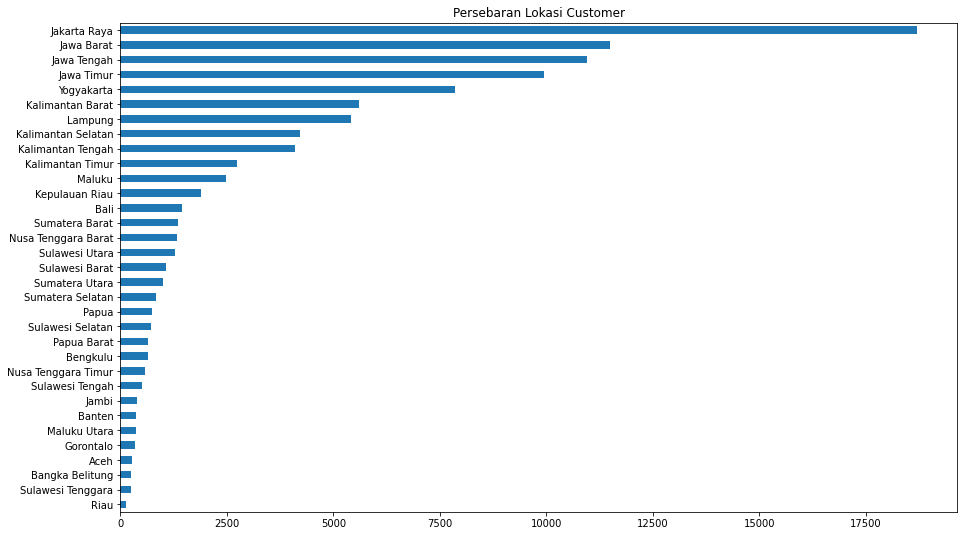

In [ ]:
customer['home_location'].value_counts(ascending=True).plot.barh(figsize=(15,9), title='Persebaran Lokasi Customer')

#### Distribusi Umur Customer

In [ ]:
last_date = transaction['created_at'].max()
last_date

Timestamp('2022-07-31 23:59:45')

In [ ]:
def age(x):
  return int((last_date-x).days/365.25)

In [ ]:
customer['birthdate'] = pd.to_datetime(customer['birthdate'])

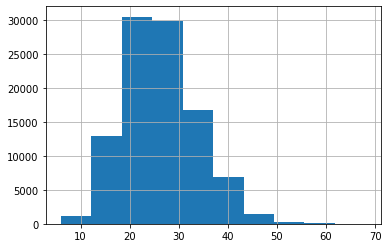

In [ ]:
customer['birthdate'].apply(lambda x: age(x)).hist()

#### OS Customer

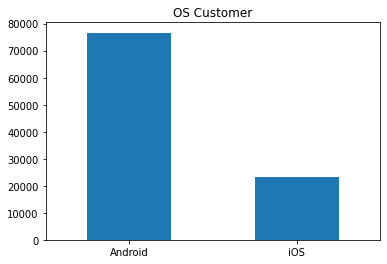

In [ ]:
customer['device_type'].value_counts().plot.bar(title='OS Customer',rot=0)

### Feature Engineering

In [ ]:
customer['name'] = customer['first_name'].str.cat(customer['last_name'],sep=" ")

In [ ]:
customer['age'] = customer['birthdate'].apply(lambda x: age(x))

In [ ]:
gen = pd.get_dummies(customer['gender'], drop_first = False)
dev = pd.get_dummies(customer['device_type'], drop_first = False)
loc = pd.get_dummies(customer['home_location'], drop_first = False)

In [ ]:
gen_os = pd.concat([gen,dev],sort=False,axis=1)

In [ ]:
gen_os

,F,M,Android,iOS
0,1,0,0,1
1,1,0,1,0
2,0,1,0,1
3,0,1,0,1
4,0,1,0,1
...,...,...,...,...
99995,0,1,1,0
99996,0,1,1,0
99997,1,0,1,0
99998,0,1,1,0


In [ ]:
customer = pd.concat([customer,gen_os], sort=False,axis=1)

In [ ]:
customer_mod = customer

In [ ]:
customer.columns

Index(['customer_id', 'first_name', 'last_name', 'username', 'email', 'gender',
       'birthdate', 'device_type', 'device_id', 'device_version',
       'home_location_lat', 'home_location_long', 'home_location',
       'home_country', 'first_join_date', 'name', 'age', 'F', 'M', 'Android',
       'iOS'],
      dtype='object')

In [ ]:
customer_mod = customer.drop(columns = ['first_name', 'last_name', 'email', 'gender',
       'birthdate', 'device_type', 'device_id', 'device_version',
       'home_location_lat', 'home_location_long', 'home_location',
       'home_country', 'first_join_date'])

In [ ]:
customer_mod.head()

,customer_id,username,name,age,F,M,Android,iOS
0,2870,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,Lala Maryati,26,1,0,0,1
1,8193,83be2ba7-8133-48a4-bbcb-b46a2762473f,Maimunah Laksmiwati,28,1,0,1,0
2,7279,3250e5a3-1d23-4675-a647-3281879d42be,Bakiman Simanjuntak,33,0,1,0,1
3,88813,df797edf-b465-4a80-973b-9fbb612260c2,Cahyadi Maheswara,31,0,1,0,1
4,82542,36ab08e1-03de-42a8-9e3b-59528c798824,Irnanto Wijaya,22,0,1,0,1


In [ ]:
customer_mod['name'].value_counts()

Putri Agustina     14
Rahmi Kusmawati    14
Sarah Rahimah      14
Rahmi Melani       14
Cindy Namaga       13
                   ..
Jatmiko Pradana     1
Virman Prasetyo     1
Samsul Lazuardi     1
Jabal Halim         1
Danu Pradana        1
Name: name, Length: 40430, dtype: int64

In [ ]:
customer_mod['customer_id'].value_counts().max()

1

In [ ]:
customer_mod.rename(columns = {'F':'f','M':'m','Android':'android','iOS':'ios'},inplace=True)

In [ ]:
customer_mod

,customer_id,username,name,age,f,m,android,ios
0,2870,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,Lala Maryati,26,1,0,0,1
1,8193,83be2ba7-8133-48a4-bbcb-b46a2762473f,Maimunah Laksmiwati,28,1,0,1,0
2,7279,3250e5a3-1d23-4675-a647-3281879d42be,Bakiman Simanjuntak,33,0,1,0,1
3,88813,df797edf-b465-4a80-973b-9fbb612260c2,Cahyadi Maheswara,31,0,1,0,1
4,82542,36ab08e1-03de-42a8-9e3b-59528c798824,Irnanto Wijaya,22,0,1,0,1
...,...,...,...,...,...,...,...,...
99995,34743,bf989ab1-d7eb-4ad5-b4bc-29e3cf69b35c,Manah Mustofa,21,0,1,1,0
99996,72065,4af2b3d5-c573-4032-b29c-24782745a2f6,Danu Pradana,24,0,1,1,0
99997,32818,af0edbfa-f354-4765-813b-b9f151022555,Talia Aryani,29,1,0,1,0
99998,75597,35cd82f3-6b86-42a2-bb15-933770d7f250,Ajimat Mansur,21,0,1,1,0


#### Merging with ClickStream and Transaction Data

In [ ]:
clickstream_transaction_customer_final = customer_mod.merge(transaction_clickstream_final, on='customer_id')

In [ ]:
clickstream_transaction_customer_final

,customer_id,username,name,age,f,m,android,ios,mobile,web,...,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,before_cutoff,after_cutoff,customer_type
0,7279,3250e5a3-1d23-4675-a647-3281879d42be,Bakiman Simanjuntak,33,0,1,0,1,1257,41,...,1,1,1,1,1,10,79,1,1,not_churn
1,82542,36ab08e1-03de-42a8-9e3b-59528c798824,Irnanto Wijaya,22,0,1,0,1,9,0,...,0,0,0,0,1,0,1,0,0,inactive
2,96453,44e67d0f-4743-479c-a74b-fc853ea5b355,Talia Hastuti,17,1,0,1,0,20,0,...,0,0,0,0,1,1,1,1,0,churn
3,8031,c5969dbf-c32b-428c-b8f4-a430def3befd,Ana Laksmiwati,26,1,0,0,1,13,12,...,1,0,0,0,0,0,3,0,0,inactive
4,9152,9f6bf5e5-c8dc-4684-a258-4ebf4416c519,Olivia Hariyah,26,1,0,0,1,28,0,...,1,0,1,0,0,0,3,0,0,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50699,38690,7b8a0263-c051-4cb8-871f-5e3f2188e8c1,Dewi Puspasari,40,1,0,1,0,50,0,...,1,1,0,0,1,1,5,0,0,inactive
50700,34743,bf989ab1-d7eb-4ad5-b4bc-29e3cf69b35c,Manah Mustofa,21,0,1,1,0,575,177,...,1,1,1,1,1,2,35,1,1,not_churn
50701,72065,4af2b3d5-c573-4032-b29c-24782745a2f6,Danu Pradana,24,0,1,1,0,324,126,...,1,1,1,1,1,3,41,1,1,not_churn
50702,32818,af0edbfa-f354-4765-813b-b9f151022555,Talia Aryani,29,1,0,1,0,1450,109,...,1,1,1,1,1,0,96,1,1,not_churn


## Reverse Encoding

In [ ]:
clickstream_transaction_customer_final_rev = clickstream_transaction_customer_final

In [ ]:
clickstream_transaction_customer_final_rev['gender'] = clickstream_transaction_customer_final[['f','m']].idxmax(1)

In [ ]:
clickstream_transaction_customer_final_rev['os'] = clickstream_transaction_customer_final[['android','ios']].idxmax(1)

In [ ]:
def plat(x0, x1):
  if x0 > x1:
    return 'mobile'
  elif x0 < x1:
    return 'web'

In [ ]:
clickstream_transaction_customer_final_rev['pref_platform'] = clickstream_transaction_customer_final[['mobile','web']].apply(lambda x: plat(x[0],x[1]), axis=1)

In [ ]:
clickstream_transaction_customer_final_rev.drop(columns=['f','m','android','ios','mobile','web'],inplace=True)

In [ ]:
clickstream_transaction_customer_final_rev

,customer_id,username,name,age,add_promo,add_to_cart,booking,click,homepage,item_detail,...,linkaja,ovo,fail_transaction,success_transaction,before_cutoff,after_cutoff,customer_type,gender,os,pref_platform
0,7279,3250e5a3-1d23-4675-a647-3281879d42be,Bakiman Simanjuntak,33,18,118,89,272,244,157,...,1,1,10,79,1,1,not_churn,m,ios,mobile
1,82542,36ab08e1-03de-42a8-9e3b-59528c798824,Irnanto Wijaya,22,0,3,1,1,3,1,...,0,1,0,1,0,0,inactive,m,ios,mobile
2,96453,44e67d0f-4743-479c-a74b-fc853ea5b355,Talia Hastuti,17,1,5,2,3,3,1,...,0,1,1,1,1,0,churn,f,android,mobile
3,8031,c5969dbf-c32b-428c-b8f4-a430def3befd,Ana Laksmiwati,26,3,6,3,3,4,2,...,0,0,0,3,0,0,inactive,f,ios,mobile
4,9152,9f6bf5e5-c8dc-4684-a258-4ebf4416c519,Olivia Hariyah,26,2,12,3,3,4,2,...,0,0,0,3,0,0,inactive,f,ios,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50699,38690,7b8a0263-c051-4cb8-871f-5e3f2188e8c1,Dewi Puspasari,40,3,14,6,8,7,1,...,0,1,1,5,0,0,inactive,f,android,mobile
50700,34743,bf989ab1-d7eb-4ad5-b4bc-29e3cf69b35c,Manah Mustofa,21,12,45,37,182,133,84,...,1,1,2,35,1,1,not_churn,m,android,mobile
50701,72065,4af2b3d5-c573-4032-b29c-24782745a2f6,Danu Pradana,24,13,118,44,74,81,33,...,1,1,3,41,1,1,not_churn,m,android,mobile
50702,32818,af0edbfa-f354-4765-813b-b9f151022555,Talia Aryani,29,36,157,96,350,296,145,...,1,1,0,96,1,1,not_churn,f,android,mobile


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
clickstream_transaction_customer_final_rev.to_excel('/content/drive/My Drive/gds2.xls',encoding='uft-8')

<ipython-input-124-bb6072361338>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  clickstream_transaction_customer_final_rev.to_excel('/content/drive/My Drive/gds2.xls',encoding='uft-8')


In [ ]:
clickstream_transaction_customer_final.columns

Index(['customer_id', 'username', 'name', 'age', 'add_promo', 'add_to_cart',
       'booking', 'click', 'homepage', 'item_detail', 'promo_page', 'scroll',
       'search', 'promo_amount', 'shipment_fee', 'total_amount', 'credit_card',
       'debit_card', 'gopay', 'linkaja', 'ovo', 'fail_transaction',
       'success_transaction', 'before_cutoff', 'after_cutoff', 'customer_type',
       'gender', 'os', 'pref_platform'],
      dtype='object')

#Machine Learning

## Cleaning Data

In [ ]:
customer_type = clickstream_transaction_customer_final.drop(columns=['customer_id','username', 'name','before_cutoff','after_cutoff'])

In [ ]:
pre_churn = customer_type[(customer_type['customer_type'] == 'churn') | (customer_type['customer_type'] == 'not_churn') ]

In [ ]:
pre_churn

,age,add_promo,add_to_cart,booking,click,homepage,item_detail,promo_page,scroll,search,...,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,customer_type,gender,os,pref_platform
0,33,18,118,89,272,244,157,59,201,140,...,1,1,1,1,10,79,not_churn,m,ios,mobile
2,17,1,5,2,3,3,1,1,2,2,...,0,0,0,1,1,1,churn,f,android,mobile
5,36,3,35,10,31,29,9,11,14,9,...,1,1,0,1,0,10,churn,m,android,mobile
6,24,32,103,68,221,214,106,60,186,127,...,1,1,1,1,8,60,not_churn,f,android,mobile
7,30,1,3,2,5,3,3,0,2,0,...,1,0,0,0,0,2,churn,f,android,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50696,26,2,7,5,8,7,1,1,3,1,...,0,1,0,0,0,5,churn,m,android,mobile
50700,21,12,45,37,182,133,84,32,122,105,...,1,1,1,1,2,35,not_churn,m,android,mobile
50701,24,13,118,44,74,81,33,11,46,30,...,1,1,1,1,3,41,not_churn,m,android,mobile
50702,29,36,157,96,350,296,145,66,239,174,...,1,1,1,1,0,96,not_churn,f,android,mobile


In [ ]:
churn = pre_churn

In [ ]:
churn['customer_type'].astype(str)

0        not_churn
2            churn
5            churn
6        not_churn
7            churn
           ...    
50696        churn
50700    not_churn
50701    not_churn
50702    not_churn
50703    not_churn
Name: customer_type, Length: 30661, dtype: object

In [ ]:
def churn_def(x):
  if x == 'churn':
    return 1
  elif x == 'not_churn':
    return 0

In [ ]:
churn['churn'] = churn['customer_type'].apply(lambda x: churn_def(x))

<ipython-input-132-41e1e3eed005>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn['churn'] = churn['customer_type'].apply(lambda x: churn_def(x))


In [ ]:
churn.drop(columns=['customer_type'],inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Final Data

In [ ]:
churn

,age,add_promo,add_to_cart,booking,click,homepage,item_detail,promo_page,scroll,search,...,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,gender,os,pref_platform,churn
0,33,18,118,89,272,244,157,59,201,140,...,1,1,1,1,10,79,m,ios,mobile,0
2,17,1,5,2,3,3,1,1,2,2,...,0,0,0,1,1,1,f,android,mobile,1
5,36,3,35,10,31,29,9,11,14,9,...,1,1,0,1,0,10,m,android,mobile,1
6,24,32,103,68,221,214,106,60,186,127,...,1,1,1,1,8,60,f,android,mobile,0
7,30,1,3,2,5,3,3,0,2,0,...,1,0,0,0,0,2,f,android,mobile,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50696,26,2,7,5,8,7,1,1,3,1,...,0,1,0,0,0,5,m,android,mobile,1
50700,21,12,45,37,182,133,84,32,122,105,...,1,1,1,1,2,35,m,android,mobile,0
50701,24,13,118,44,74,81,33,11,46,30,...,1,1,1,1,3,41,m,android,mobile,0
50702,29,36,157,96,350,296,145,66,239,174,...,1,1,1,1,0,96,f,android,mobile,0


### Churn Proportion

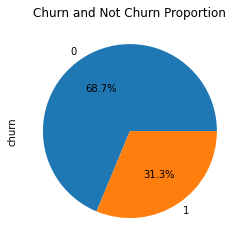

In [ ]:
churn['churn'].value_counts().plot.pie(autopct = '%1.1f%%',title='Churn and Not Churn Proportion')

In [ ]:
churn['churn'].value_counts()

0    21075
1     9586
Name: churn, dtype: int64

##Baseline Model : KNN

In [ ]:
churn.drop(columns=['gender','os','pref_platform'],inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
churn.head()

,age,add_promo,add_to_cart,booking,click,homepage,item_detail,promo_page,scroll,search,...,shipment_fee,total_amount,credit_card,debit_card,gopay,linkaja,ovo,fail_transaction,success_transaction,churn
0,33,18,118,89,272,244,157,59,201,140,...,825000,48693665,1,1,1,1,1,10,79,0
2,17,1,5,2,3,3,1,1,2,2,...,20000,400724,0,0,0,0,1,1,1,1
5,36,3,35,10,31,29,9,11,14,9,...,70000,2811080,1,1,1,0,1,0,10,1
6,24,32,103,68,221,214,106,60,186,127,...,480000,32296024,1,1,1,1,1,8,60,0
7,30,1,3,2,5,3,3,0,2,0,...,0,547180,0,1,0,0,0,0,2,1


In [ ]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30661 entries, 0 to 50703
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  30661 non-null  int64
 1   add_promo            30661 non-null  int64
 2   add_to_cart          30661 non-null  int64
 3   booking              30661 non-null  int64
 4   click                30661 non-null  int64
 5   homepage             30661 non-null  int64
 6   item_detail          30661 non-null  int64
 7   promo_page           30661 non-null  int64
 8   scroll               30661 non-null  int64
 9   search               30661 non-null  int64
 10  promo_amount         30661 non-null  int64
 11  shipment_fee         30661 non-null  int64
 12  total_amount         30661 non-null  int64
 13  credit_card          30661 non-null  int64
 14  debit_card           30661 non-null  int64
 15  gopay                30661 non-null  int64
 16  linkaja              3

Kita ingin mengetahui customer churn atau tidak, maka digunakan model machine learning tipe Classification yaitu kNN.

Model ML yang digunakan adalah kNN.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X = churn.drop('churn', axis=1).values
y = churn['churn'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.score(X_test,y_test)

0.7448230882113158

Untuk k = 3, maka akurasi model KNN nya adalah 74,48%.



### Akurasi Model

In [ ]:
neighbors = np.arange(1, 26)
test_accuracies = {}

for neighbor in neighbors:

  	# Set up a KNN Classifier
  	knn = KNeighborsClassifier(n_neighbors=neighbor)

  	# Fit the model
  	knn.fit(X_train, y_train)

  	# Compute accuracy
  	test_accuracies[neighbor] = knn.score(X_test, y_test)

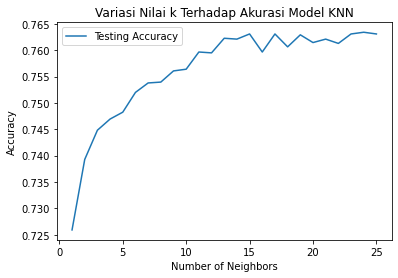

In [ ]:
plt.title("Variasi Nilai k Terhadap Akurasi Model KNN")
plt.plot(neighbors, list(test_accuracies.values()), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

Terlihat untuk k-15, akurasi cenderung tidak berubah terlalu jauh (cenderung asimtot horizontal)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train,y_train)
knn.predict(X_test)
knn.score(X_test,y_test)

0.7630849502690363

Untuk k = 15, akurasi model mencapai 76,31%

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, fbeta_score

In [ ]:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

In [ ]:
results = pd.DataFrame([[
'KNN', acc, prec, rec, f1, f2]],
 columns = ['Model', 'Accuracy', 'Precision',
'Recall', 'F1 Score', 'F2 Score'])

In [ ]:
print (results)

  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0   KNN  0.744823   0.594624  0.576943   0.58565  0.580395


### k-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
knn_cv = KNeighborsClassifier(n_neighbors=15)

In [ ]:
cv_scores = cross_val_score(knn_cv, X, y, cv=5)

In [ ]:
print(cv_scores)
print('cv_scores_mean:{}'.format(np.mean(cv_scores)))

[0.75069297 0.75326158 0.75896934 0.75668624 0.75684932]
cv_scores_mean:0.755291888683221


Menggunakan metode k-Fold, diketahui rata-rata akurasi model yang dibuat adalah 75,53%

### Confusion Matrix

Text(0.5, 15.0, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

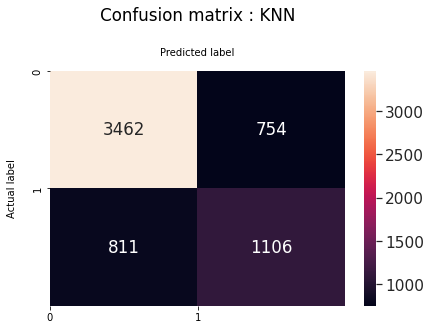

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu"
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix : KNN\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

### ROC Curve

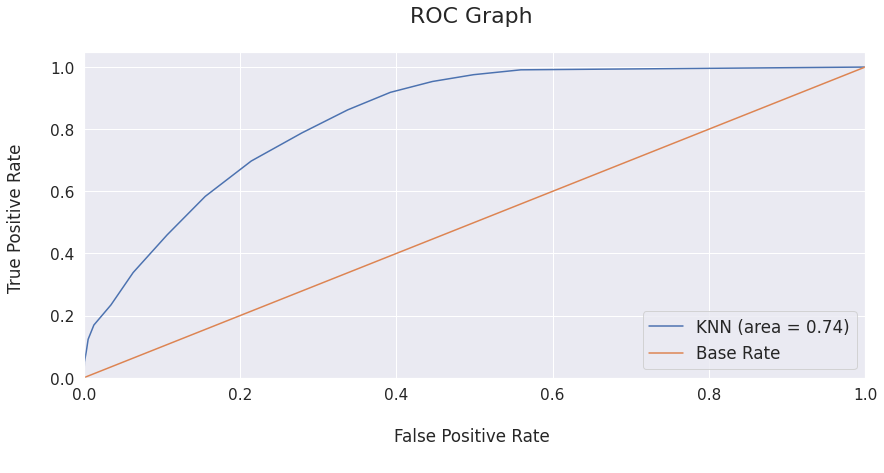

In [ ]:
classifier = knn_cv

classifier.fit(X_train, y_train)
probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr,
label='KNN (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "22",
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

# Model Lainnya

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Fitting Decision Tree to the Training set:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

In [ ]:
model_results = pd.DataFrame([[
'Decision Tree', acc, prec, rec, f1, f2]],
 columns = ['Model', 'Accuracy', 'Precision',
'Recall', 'F1 Score', 'F2 Score'])

In [ ]:
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision",
"Recall", "F2 Score"], ascending = False)
print (results)

           Model  Accuracy  Precision    Recall  F1 Score  F2 Score
1  Decision Tree  0.779064   0.646813  0.645801  0.646306  0.646003
0            KNN  0.744823   0.594624  0.576943  0.585650  0.580395


### Confusion Matrix

Text(0.5, 7.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

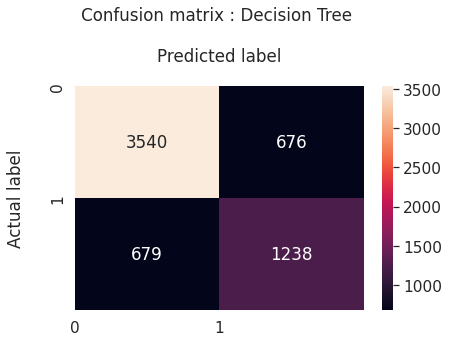

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu"
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix : Decision Tree \n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

### ROC Curve

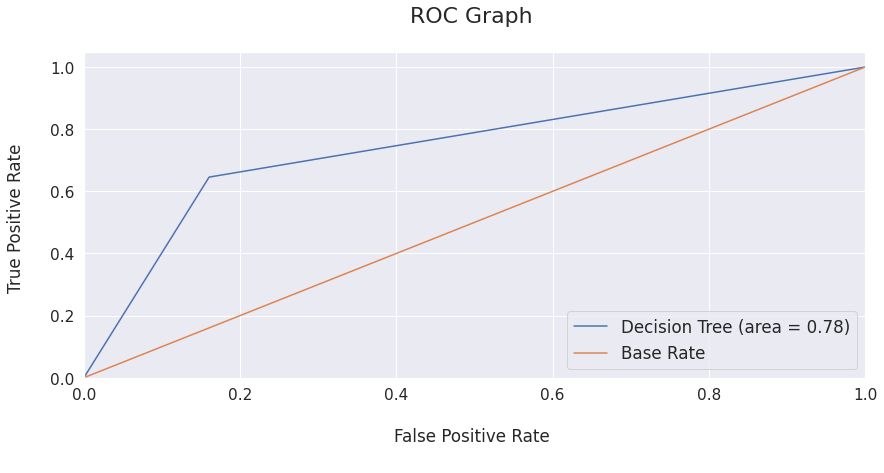

In [ ]:
classifier.fit(X_train, y_train)
probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr,
label='Decision Tree (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "22",
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Fitting Logistic Regression to the Training set
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

In [ ]:
model_results = pd.DataFrame([['Logistic Regression',
acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision',
'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision",
"Recall", "F2 Score"], ascending = False)
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
2  Logistic Regression  0.693951   0.743902  0.031821  0.061031  0.039355
0        Decision Tree  0.779064   0.646813  0.645801  0.646306  0.646003
1                  KNN  0.744823   0.594624  0.576943  0.585650  0.580395


### Confusion Matrix

Text(0.5, 7.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

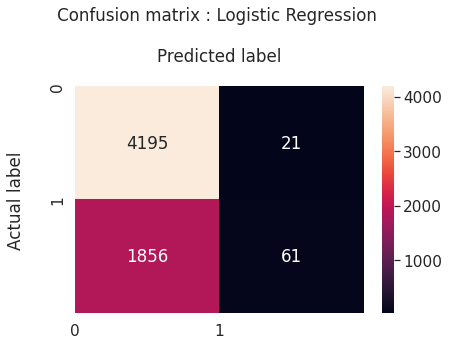

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu"
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix : Logistic Regression \n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

### ROC Curve

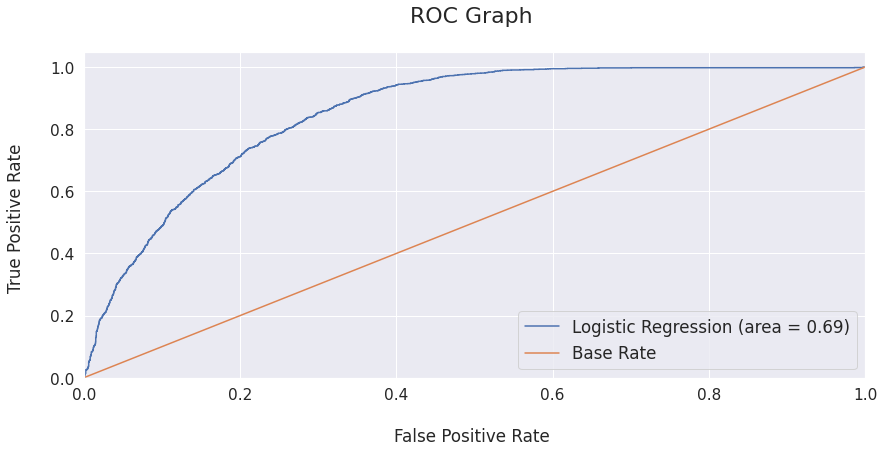

In [ ]:
classifier.fit(X_train, y_train)
probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr,
label='Logistic Regression (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "22",
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Fitting Naive Byes to the Training set:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
#Evaluate results
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

In [ ]:
model_results = pd.DataFrame([['Naive Bayes',
acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision',
'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision",
"Recall", "F2 Score"], ascending = False)
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.693951   0.743902  0.031821  0.061031  0.039355
1        Decision Tree  0.779064   0.646813  0.645801  0.646306  0.646003
2                  KNN  0.744823   0.594624  0.576943  0.585650  0.580395
3          Naive Bayes  0.608022   0.443280  0.992697  0.612882  0.795502


### Confusion Matrix

Text(0.5, 7.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

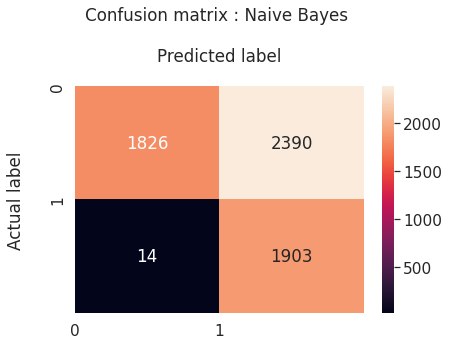

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu"
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix : Naive Bayes \n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

### ROC Curve

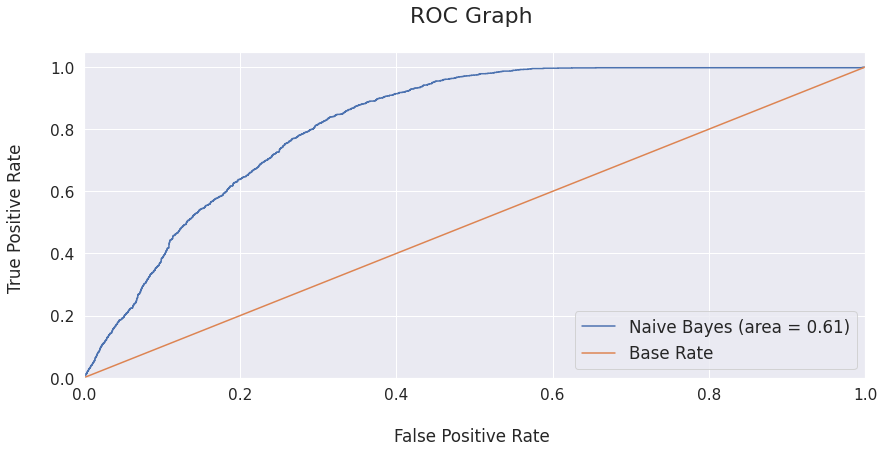

In [ ]:
classifier.fit(X_train, y_train)
probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr,
label='Naive Bayes (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "22",
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Fitting Random Forest to the Training set:

classifier = RandomForestClassifier(n_estimators = 72,
criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=72, random_state=0)

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
#Evaluate results
accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)
model_results = pd.DataFrame([['Random Forest',
acc, prec, rec, f1, f2]],
columns = ['Model', 'Accuracy', 'Precision',
'Recall', 'F1 Score', 'F2 Score'])
results = results.append(model_results, ignore_index = True)
results = results.sort_values(["Precision",
"Recall", "F2 Score"], ascending = False)
print (results)

                 Model  Accuracy  Precision    Recall  F1 Score  F2 Score
0  Logistic Regression  0.693951   0.743902  0.031821  0.061031  0.039355
4        Random Forest  0.811675   0.687500  0.728743  0.707521  0.720103
1        Decision Tree  0.779064   0.646813  0.645801  0.646306  0.646003
2                  KNN  0.744823   0.594624  0.576943  0.585650  0.580395
3          Naive Bayes  0.608022   0.443280  0.992697  0.612882  0.795502


### Confusion Matrix

Text(0.5, 7.5, 'Predicted label\n')

<Figure size 2016x1440 with 0 Axes>

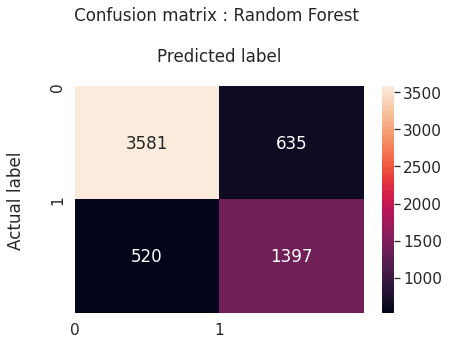

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))
fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu"
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix : Random Forest \n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')

### ROC Curve

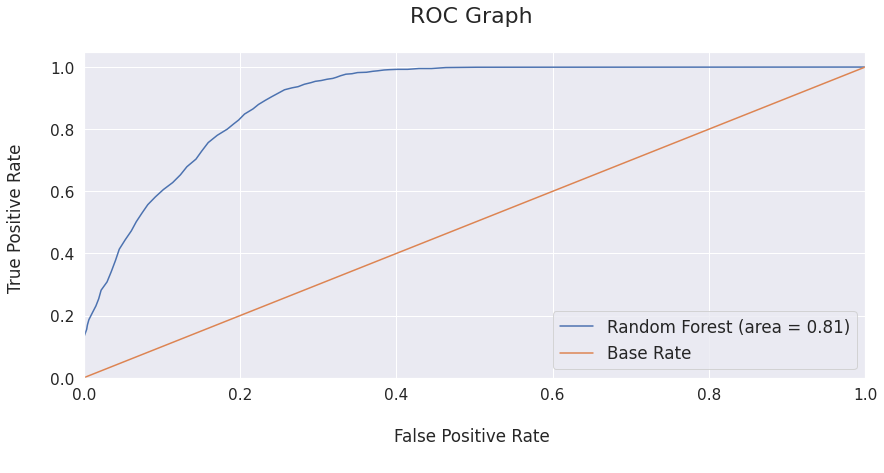

In [ ]:
classifier.fit(X_train, y_train)
probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
classifier_roc_auc = accuracy_score(y_test, y_pred )
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))
# Plot Logistic Regression ROC
plt.plot(rf_fpr, rf_tpr,
label='Random Forest (area = %0.2f)' % classifier_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('True Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "medium",
fontfamily = "sans-serif")
plt.title('ROC Graph \n',horizontalalignment="center",
fontstyle = "normal", fontsize = "22",
fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
plt.show()

## ROC Scores

In [ ]:
from sklearn import model_selection

In [ ]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0,
                                                         class_weight='balanced')))
models.append(('KNN', KNeighborsClassifier(n_neighbors = 15, metric = 'minkowski', p = 2)))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, criterion = 'entropy', random_state = 0)))
#Evaluating Model Results:
acc_results = []
auc_results = []
names = []
# set table to table to populate with performance results
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD',
       'Accuracy Mean', 'Accuracy STD']
roc_results = pd.DataFrame(columns=col)
i = 0
# Evaluate each model using k-fold cross-validation:
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=0, shuffle=True)
    # accuracy scoring:
    cv_acc_results = model_selection.cross_val_score(
    model, X_train, y_train, cv=kfold, scoring='accuracy')
    # roc_auc scoring:
    cv_auc_results = model_selection.cross_val_score(
    model, X_train, y_train, cv=kfold, scoring='roc_auc')
    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    roc_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1

roc_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
4,Random Forest,89.41,0.25,80.83,0.18
0,Logistic Regression,84.64,0.41,69.83,0.50
1,KNN,83.52,0.51,75.50,0.43
2,Gaussian Naive Bayes,82.13,0.86,61.00,0.83
3,Decision Tree Classifier,73.01,0.81,76.74,0.82


# Feature Importance

In [ ]:
importances = classifier.feature_importances_

In [ ]:
sorted_indices = np.argsort(importances)[::-1]

feat_labels = churn.columns[:-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))

 1) scroll                         0.120373
 2) click                          0.104474
 3) booking                        0.082642
 4) success_transaction            0.076745
 5) total_amount                   0.073123
 6) homepage                       0.068653
 7) shipment_fee                   0.067225
 8) promo_amount                   0.063726
 9) item_detail                    0.060421
10) add_to_cart                    0.059770
11) search                         0.052621
12) age                            0.045745
13) promo_page                     0.036865
14) add_promo                      0.033124
15) fail_transaction               0.011485
16) ovo                            0.008791
17) debit_card                     0.008716
18) gopay                          0.008679
19) credit_card                    0.008548
20) linkaja                        0.008271


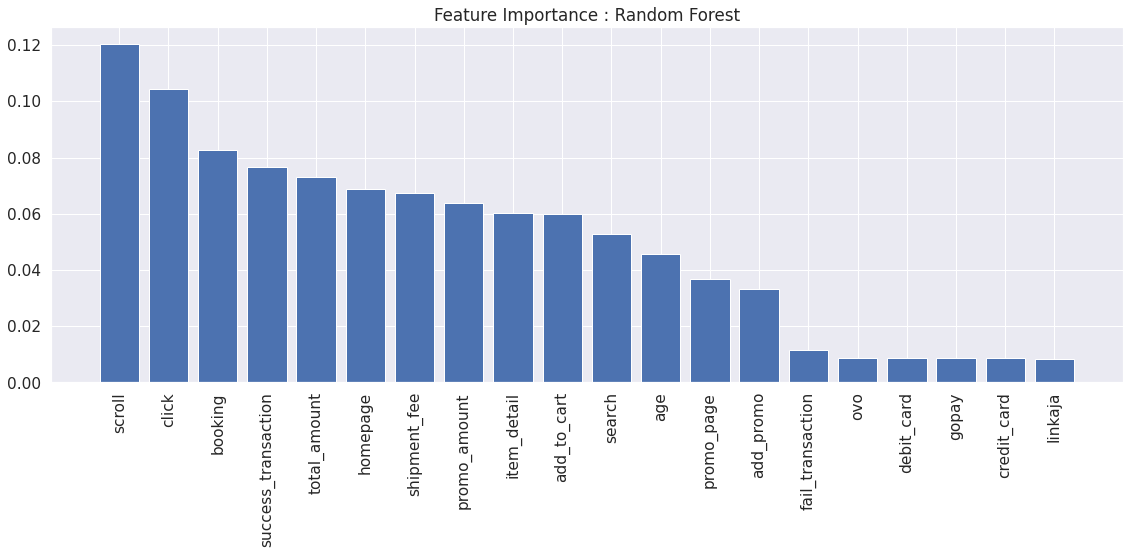

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Feature Importance : Random Forest')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), churn.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
np.array(churn.columns[sorted_indices])

array(['scroll', 'click', 'booking', 'success_transaction',
       'total_amount', 'homepage', 'shipment_fee', 'promo_amount',
       'item_detail', 'add_to_cart', 'search', 'age', 'promo_page',
       'add_promo', 'fail_transaction', 'ovo', 'debit_card', 'gopay',
       'credit_card', 'linkaja'], dtype=object)

In [ ]:
importances[sorted_indices]

array([0.12037269, 0.10447416, 0.08264237, 0.07674516, 0.07312332,
       0.06865332, 0.0672253 , 0.06372599, 0.06042134, 0.05977009,
       0.05262073, 0.04574519, 0.03686533, 0.03312363, 0.01148469,
       0.00879144, 0.00871596, 0.00867949, 0.00854835, 0.00827144])

In [ ]:
feature_importances = pd.DataFrame({'feature': list(np.array(churn.columns[sorted_indices])), 'importances': list(importances[sorted_indices])}, columns=['features', 'importances'])

In [ ]:
feature_importances.to_excel('/content/drive/My Drive/feature.xls',encoding='uft-8')

<ipython-input-195-ac559650758b>:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  feature_importances.to_excel('/content/drive/My Drive/feature.xls',encoding='uft-8')
